## Binary Classification: Dogs vs. Cats
https://www.kaggle.com/c/dogs-vs-cats/data

** Dataset Information: **

- 25,000 images of dogs and cats

** Attribute Information: **

- color images of dogs and cats

** Objective of this project **

- distinguish dogs from cats

## Data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline

Using TensorFlow backend.


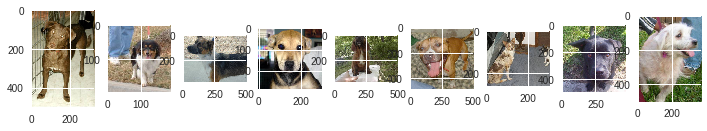

In [4]:
filepath = 'drive/app/cat_or_dog/'
# plot the first 9 dogs
plt.figure(figsize=(12,6))
for i in range(0, 9):
    plt.subplot(190 + (i+1))
    plt.imshow(image.load_img(filepath+'train_set/dogs/dog.'+str(i+1)+'.jpg'))

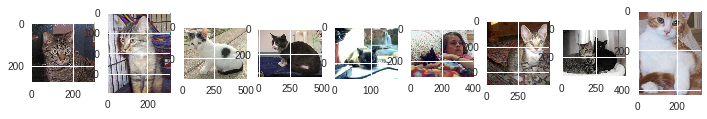

In [5]:
# plot the first 9 cats
plt.figure(figsize=(12,6))
for i in range(0, 9):
    plt.subplot(190 + (i+1))
    plt.imshow(image.load_img(filepath+'train_set/cats/cat.'+str(i+1)+'.jpg'))

## Mini-batch

In [33]:
from keras.preprocessing.image import ImageDataGenerator

# Generate minibatches of image data with real-time data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# read image data
batch_size = 32

train_set = train_datagen.flow_from_directory(filepath+'train_set',
                                                 target_size = (128, 128),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(filepath+'test_set',
                                            target_size = (128, 128),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Model: vgg16+dense

### Train Model

In [34]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import applications
import keras.backend as K

seed = 101
np.random.seed(seed)
K.clear_session()
epochs = 50
filepath_model = filepath+'weights_best_model.hdf5'

# pretrained vgg16 model
base_model = applications.VGG16(include_top=False, weights='imagenet',
                               input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False
    
# add top layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# callbacks
early_stop = EarlyStopping(monitor='val_acc', patience=3, verbose=0, mode='max')
checkpoint = ModelCheckpoint(filepath_model, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint, early_stop]

# train the model
model.fit_generator(train_set, 
                    steps_per_epoch = 8000 // batch_size, 
                    epochs = epochs, 
                    validation_data = test_set, 
                    validation_steps = 2000 // batch_size,
                    callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

### Evaluate Model

Accuracy:	90.5%
roc auc:	0.905


             precision    recall  f1-score   support

        0.0       0.91      0.89      0.90       993
        1.0       0.90      0.92      0.91       991

avg / total       0.90      0.90      0.90      1984



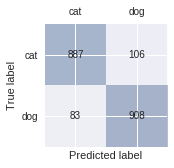

In [44]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score
from itertools import islice

# predict class with test set
X_test = []
y_test = []
for ts in islice(test_set, 2000 // batch_size):
    X_test.append(ts[0])
    y_test.append(ts[1])
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

model.load_weights(filepath_model)
y_pred_test =  model.predict(X_test)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(y_test,y_pred_test>0.5)*100))
print('roc auc:\t{:0.3f}'.format(roc_auc_score(y_test,y_pred_test>0.5)))

#classification report
print('\n')
print(classification_report(y_test, y_pred_test>0.5))

#confusion matrix
confmat = confusion_matrix(y_test, y_pred_test>0.5)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xticks((0,1),('cat', 'dog'))
plt.yticks((0,1),('cat', 'dog'))  
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

### Make Predictions

In [0]:
def cat_or_dog(filename):    
    test_image = image.load_img(filepath+'prediction/'+filename, target_size = (128,128)) #(64, 64))
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        return 'dog'
    else:
        return 'cat'

'dog'

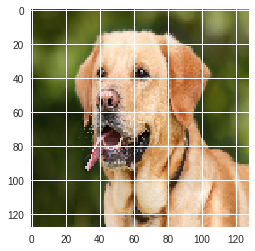

In [46]:
cat_or_dog('cat_or_dog_1.jpg')

'cat'

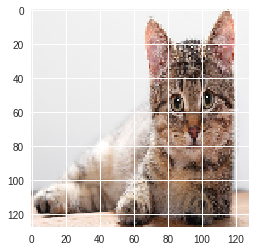

In [51]:
cat_or_dog('cat_or_dog_2.jpg')

'cat'

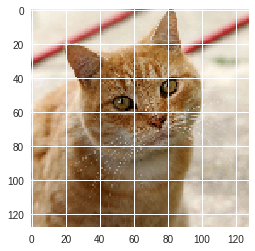

In [48]:
cat_or_dog('cat_or_dog_3.jpg')

'dog'

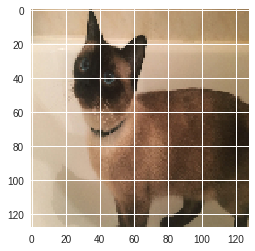

In [49]:
cat_or_dog('cat_or_dog_4.jpg')

'cat'

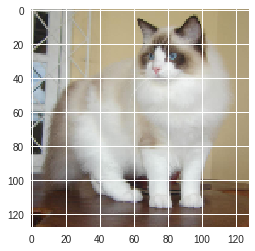

In [50]:
cat_or_dog('cat_or_dog_5.jpg')